
# **Taranaki Regional Council: Environmental Data**
---
Taranaki Regional Council make available a variety of environmental data through their website: https://www.trc.govt.nz/environment/maps-and-data/regional-overview  

From within each site various data is collected, for example
<ul><li>wind (direction, speed, gust)</li> <li>rainfall</li> <li>river (flow, height, dissolved O2, temperature)</li> <li>soil (moisture, temperature)</li></ul>
Data is available for<ul><li>365 days (daily record)</li> <li>30 days (hourly record)</li><li>7 days (10 minute record)</li></ul>
It is possible to set a starting from date to compile historical data sets from the regional council website, e.g. you could use timePeriod=365days and then use
&fromDate= to compile several years of daily data.

---

One problem I have found with this website is that the initial map can not be relied on to show a pin for every site for which data is collected. As there is no index of site/measure combinations that I can find, I created a short script that will check the website for any given site and measure id. If the combination is valid and data is available, then this builds up a list that can be inspected later. This takes some time to run, but would only need to be run once to get a list into your own environment.
This script df_all_measures is in the src folder of this repo.

---

This notebook shows the possibilities of combining multiple measure types for a site together which is not possible in the regional council website itself.
The examples below pull wind speed, wind direction and rainfall for site Kapoaiaia at Cape Egmont. 

---

In [1]:
import pandas as pd
import requests
import json
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Hard coded lookup tables with a sample of sites and measures available through the TRC website
from src.TRCSampleDF import sites_dataframe, measures_dataframe

# Define url parts for accessing TRC Environmental Data
base_url = "https://www.trc.govt.nz/environment/maps-and-data/site-details/LoadGraphAndListData/"
site_link = "?siteID="
measure_link = "&measureID="
time_link = "&timePeriod="
date_link = "&fromDate="

# Set up dataframes with the id codes that are passed into the url when building the master data dataframe
df_sites = sites_dataframe()
df_measures = measures_dataframe()

# Grab all sites that get data for both wind direction, wind speed and rainfall
df_example = df_sites[(df_sites['wd'] == True) & (df_sites['ws'] == True) & (df_sites['rf'] == True)]
df_example_measures = pd.DataFrame({'id': ['4', '2', '1'], 'measure_id': ['wd', 'ws', 'rf'], 'measure_label': ['Wind Direction', 'Wind Speed', 'Rainfall']})

df_data_full = pd.DataFrame()

# Outer loop is by site
for i in range(0, len(df_example)):
    site_id = str(df_example.iloc[i,0])
    
    # Inner loop is by measure
    for j in range(0, len(df_example_measures)):
        measure_id = df_example_measures.iloc[j,0]
        measure_tag = df_example_measures.iloc[j,1]
        url_link = base_url + site_link + site_id + measure_link + measure_id + time_link + "365days"

        try:
            response = requests.get(url_link)
            response.raise_for_status()
            response_data_string = response.text
            data = json.loads(response_data_string)
            raw_data = data.get('highStockData')
       
            if raw_data:
                df_data = pd.DataFrame(raw_data, columns=['timestamp', 'value'])
                df_data['timestamp'] = pd.to_datetime(df_data['timestamp'], unit='ms')
                df_data['year'] = pd.DatetimeIndex(df_data['timestamp']).year
                df_data['month'] = pd.DatetimeIndex(df_data['timestamp']).month
                df_data['mm-yyyy'] = df_data['timestamp'].apply(lambda x: x.strftime('%Y-%m'))#x.strftime('%B-%y'))
                df_data['site'] = int(site_id)
                df_data['measure'] = measure_tag
        except: pass
        df_data_full = pd.concat([df_data_full, df_data])

df_result = df_data_full.merge(df_sites[['site', 'site_label']], left_on='site', right_on='site')

### **Windrose Plot**
---
The TRC webpage for environmental data displays either table data or line charts, and only for one measure at one time. For looking at patterns of wind it would be useful to combine wind speed with wind direction. A suitable visual to achieve this is the ***windrose plot*** This allows displaying of the frequency of defined wind speeds by wind direction. In the below, the objective is to display this data monthly for one site to illustrate any seasonal patterns beyond just looking at where the stronger winds come from.  

With the full dataframe now produced, the next step is to create additional columns needed to achieve this. Then define and display the plot.
---

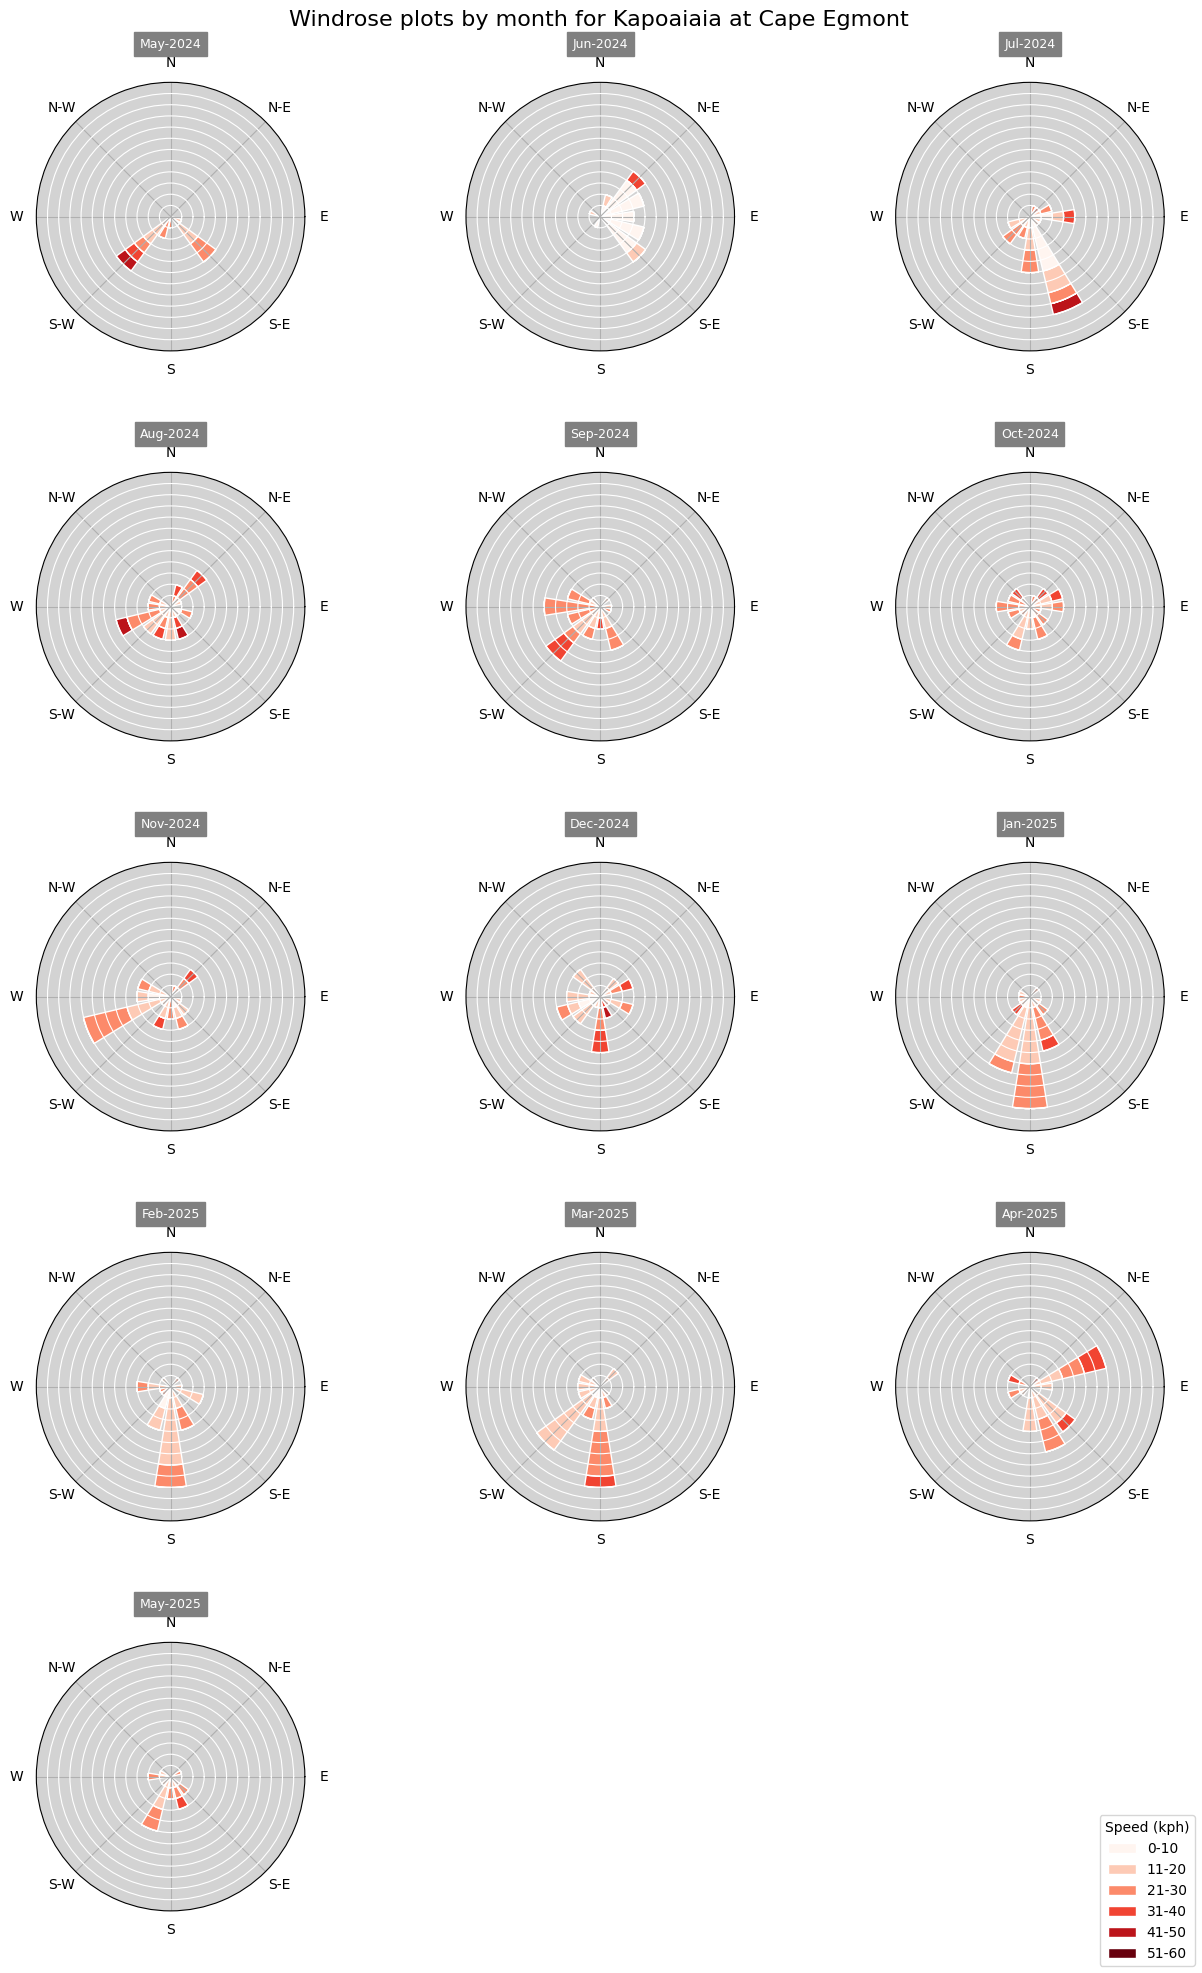

In [2]:
import numpy as np
from windrose import WindroseAxes
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

site = 'Kapoaiaia at Cape Egmont'
df_wide = df_result.pivot_table(
    index=['timestamp', 'mm-yyyy', 'site_label'],
    columns='measure',
    values='value'
).reset_index()

df_wide.columns.name = None
df_wide = df_wide.rename(columns={
    'wd': 'direction',
    'ws': 'speed'
})

# Find the maximum windspeed across the full dataset for setting bins/plot labels and ensure consistency of subplots
maxws = df_wide[['speed']].max()
maxws_up = int((((maxws / 10) + 1).round() * 10).iloc[0])
bins = list(range(0, maxws_up + 10, 10))
labels = list(map(lambda x: '0-' + str(x + 10) if x == 0 else str(x + 1) + '-' + str(x + 10) , bins))

# Filter for one site and add a bin column for wind speed
df_site = df_wide[df_wide['site_label'] == site]
df_site['Wind Bin'] = pd.cut(df_site['speed'], bins=bins, include_lowest=True)
df_site['mm-yyyy'] = pd.to_datetime(df_site['mm-yyyy'], format="%Y-%m")

# Add bins for compass points, 16 bins gives compass labels of N, NNE NE, ENE etc.
nsectors = 16
df_site['Direction Bin'] = pd.cut(
    df_site['direction'] % 360,
    bins=np.linspace(0, 360, nsectors + 1),
    right=False,
    labels=False
)

months = df_site['mm-yyyy'].sort_values().unique()
n_months = len(months)

max_freq = (df_site.groupby(['mm-yyyy','Direction Bin']).size().max())

ncols = 3
nrows = (n_months + ncols -1) // ncols

fig = plt.figure(figsize=(ncols * 4, nrows * 4))
gs = gridspec.GridSpec(nrows, ncols, figure=fig)
reds = plt.get_cmap('Reds')

for i, month in enumerate(months):
    row = i // ncols
    col = i % ncols
    ax = WindroseAxes(fig, gs[row, col])
    fig.add_axes(ax)
    
    month_data = df_site[df_site['mm-yyyy'] == month]
    ax.bar(
        month_data['direction'],
        month_data['speed'],
        bins=bins,
        label=labels,
        nsector=nsectors,
        edgecolor='white',
        cmap=reds
    )
    ax.set_title(month.strftime("%b-%Y"), fontsize = 9, backgroundcolor='grey', color='white')
    ax.set_ylim(0, max_freq-1)
    ax.set_yticks(range(0, max_freq-1, 1))
    ax.tick_params(axis='y', grid_color='white', width=0.1)
    ax.set_yticklabels([])
    ax.set_facecolor("lightgrey")
    
fig.suptitle(f"Windrose plots by month for {site}", fontsize = 16)
fig.legend(labels, title="Speed (kph)", loc="lower right")
plt.tight_layout()
plt.subplots_adjust(wspace=0.6)
plt.show()


### **Heatmap for Wind Direction vs Wind Speed**
---
Using the same data as above, another visual to examine any pattern of where stronger winds come from is a heatmap. This shows the number of days for the last year by intersection of wind direction and wind speed.
---


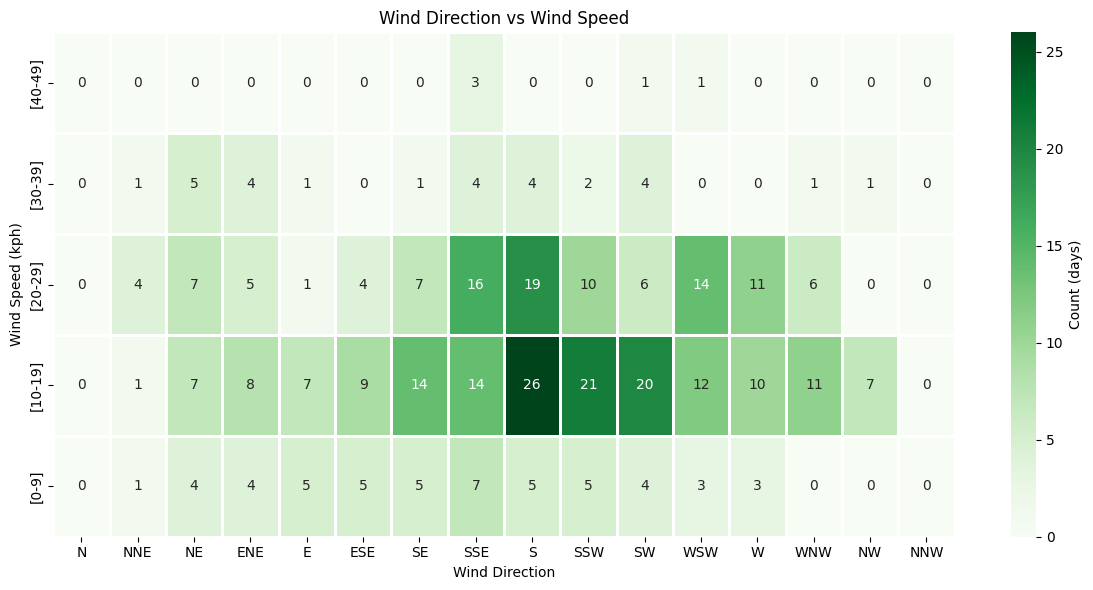

In [3]:
import seaborn as sns

# Add compass labels as a column in the dataframe to use as an axis on the heatmaps
compass_labels = ['N', 'NNE', 'NE', 'ENE',
                  'E', 'ESE', 'SE', 'SSE',
                  'S', 'SSW', 'SW', 'WSW',
                  'W', 'WNW', 'NW', 'NNW'
                  ]

df_site = df_site[df_site['direction'].notnull()]
df_site['direction_deg'] = df_site['direction'] % 360
adjusted = (df_site['direction_deg'] + 11.25) % 360
bin_idx = np.floor_divide(adjusted, 22.5).astype(int)
df_site['wind_compass'] = [compass_labels[i] for i in bin_idx]
df_site['wind_compass'] = pd.Categorical(df_site['wind_compass'], categories=compass_labels, ordered=True)

dir_speed = df_site[['wind_compass', 'Wind Bin', 'speed']]
dir_speed = dir_speed[dir_speed['Wind Bin'].notnull()]

max_speed = dir_speed['speed'].max()
bin_edges = range(0, int(max_speed) + 11, 10)
clean_labels = [f'[{i}-{i+9}]' for i in range(0, int(max_speed)+1, 10)]
dir_speed['wind_bin'] = pd.cut(dir_speed['speed'],
                               bins=bin_edges,
                               labels=clean_labels,
                               right=True,
                               include_lowest=True)
dir_speed['wind_bin'] = pd.Categorical(dir_speed['wind_bin'], categories=clean_labels[::-1], ordered=True)

dir_speed_pivot = dir_speed.pivot_table(
    index='wind_bin',
    columns='wind_compass',
    values='speed',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(12,6))
sns.heatmap(dir_speed_pivot, annot=True, linecolor='white', linewidth=1, fmt='d', cmap='Greens', cbar_kws={'label': 'Count (days)'})
plt.title('Wind Direction vs Wind Speed')
plt.ylabel('Wind Speed (kph)')
plt.xlabel('Wind Direction')
plt.tight_layout()
plt.show()

### **Heatmap for Wind Direction vs Rainfall**
---
Using the same approach as above, we can also look for patterns on which wind direction delivers the most rainfall.
---

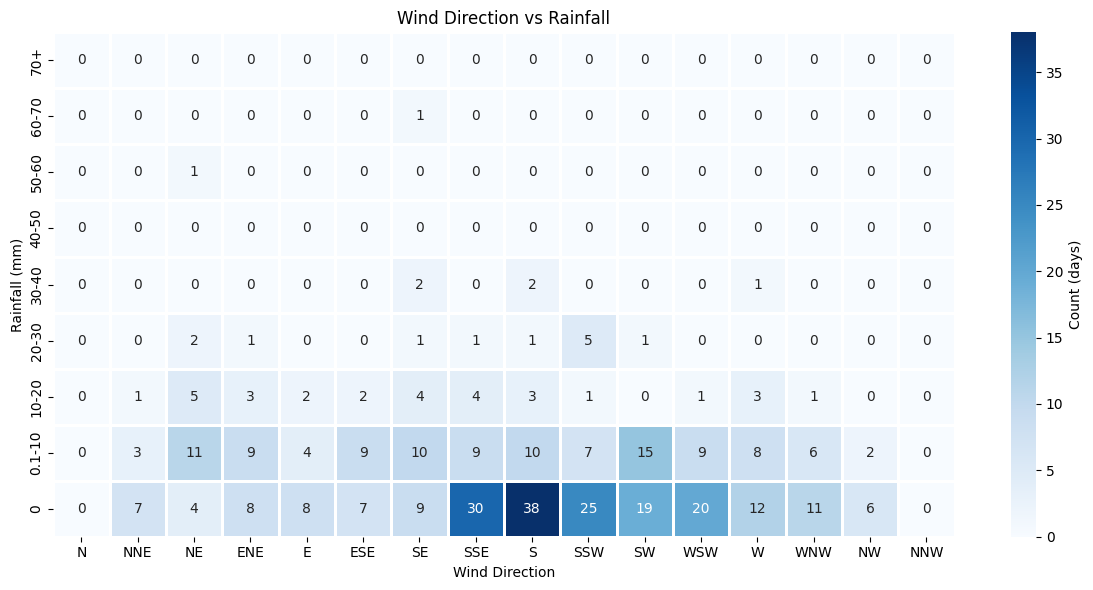

In [4]:
dir_rain = df_site[['wind_compass', 'rf']]
dir_rain = dir_rain.rename(columns={
    'rf': 'rainfall'
})
max_rain = dir_rain['rainfall'].max()
#bin_edges_rain = range(0, int(max_rain) + 11, 10)
bin_edges_rain = [0.1, 10, 20, 30, 40, 50, 60, 70, np.inf]
#clean_labels_rain = [f'[{i}-{i+9}]' for i in range(0, int(max_rain)+1, 10)]
clean_labels_rain = ['0.1-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']
dir_rain['rain_bin'] = pd.cut(dir_rain['rainfall'],
                               bins=bin_edges_rain,
                               labels=clean_labels_rain,
                               right=False
                               )
clean_labels_rain = ['0'] + clean_labels_rain
dir_rain['rain_bin'] = dir_rain['rain_bin'].astype(pd.CategoricalDtype(categories= clean_labels_rain[::-1], ordered=True))
dir_rain.loc[dir_rain['rainfall'] == 0, 'rain_bin'] = '0'

dir_rain_pivot = dir_rain.pivot_table(
    index='rain_bin',
    columns='wind_compass',
    values='rainfall',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(12,6))
sns.heatmap(dir_rain_pivot, annot=True, linecolor='white', linewidth=1, fmt='d', cmap='Blues', cbar_kws={'label': 'Count (days)'})
plt.title('Wind Direction vs Rainfall')
plt.ylabel('Rainfall (mm)')
plt.xlabel('Wind Direction')
plt.tight_layout()
plt.show()